# Aereal data to hex

This notebook __creates tables 'hex_aereal_res{res}.gpkg'__, used in notebooks that calculate HQSL and notebook aux17.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Config notebook

In [2]:
import h3
def neighbour_mean(hex_id, hex_id_name, hex_bins, col_name):
    return hex_bins.loc[hex_bins[hex_id_name].isin(h3.k_ring(hex_id,1)),col_name].mean()

In [3]:
# 'alex' or 'edgar'
all_local_dirs = 'edgar'
# Output hexs resolution           
res = 10
# save output to local?
save = True

In [4]:
if all_local_dirs == 'alex':
    grl_dir = "../../../data/processed/santiago/areal_data/"
    count_pois_dir = "../../../data/external/temporal_fromjupyter/santiago/pois/"
    ndvi_dir = "../../../data/external/temporal_todocker/santiago/ndvi_santiago/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/00_pois_formated/aereal_data/"
    count_pois_dir = grl_dir
    ndvi_dir = grl_dir
else:
    print("WARNING: Fix all_local_dirs variable")

## Create hexgrid from area of interest

In [5]:
query = 'SELECT * FROM projects_research.santiago_aoi'
aoi = aup.gdf_from_query(query)

# Working without internet connection, so:
#aoi = gpd.read_file("../../../data/processed/santiago/santiago_aoi.gpkg")
#aoi = gpd.read_file("../../../data/external/temporal_todocker/santiago/proximidad/santiago_odc_aoi_32719.gpkg")

try:
    aoi = aoi.set_crs("EPSG:4326")
except:
    aoi = aoi.to_crs("EPSG:4326")
hex_gdf = aup.create_hexgrid(aoi, res)

hex_gdf.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)

hex_gdf.to_file(f'../../../data/processed/santiago/santiago_aoi_hexres{res}.geojson')

# Show
print(hex_gdf.shape)
hex_gdf.head(1)

(210519, 2)


,hex_id,geometry
0,8ab2c5c1b6d7fff,"POLYGON ((-70.68374 -33.22990, -70.68438 -33.2..."


<AxesSubplot: >

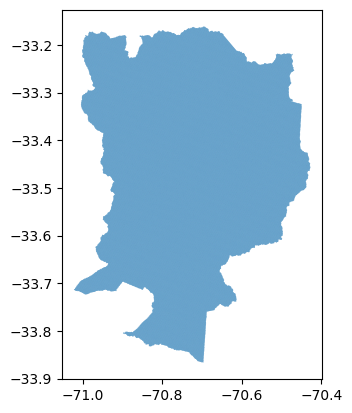

In [6]:
hex_gdf.plot()

## __Housing__

### __Housing__ - Load data

In [7]:
viv_nodes = gpd.read_file(count_pois_dir + 'casas_deptos_mzn.gpkg')
viv_nodes = viv_nodes[['osmid','total_viv','geometry']]
viv_nodes = viv_nodes.rename(columns={'total_viv':'viv_sum'})
# Show
print(viv_nodes.shape)
viv_nodes.head(2)

(214430, 3)


,osmid,viv_sum,geometry
0,14609420,20.126666,POINT (-70.75478 -33.51598)
1,266255164,21.028271,POINT (-70.79327 -33.52609)


### __Housing__ - Sum all viv by hexagon

In [8]:
viv_hexs = gpd.sjoin(viv_nodes, hex_gdf)
grouped_by = viv_hexs.groupby('hex_id').agg({'viv_sum':np.sum})
viv_gdf = grouped_by.reset_index().copy()
# Show
print(viv_gdf.shape)
viv_gdf.head(2)

(51097, 2)


,hex_id,viv_sum
0,8ab2c0b00d67fff,1.896869e-07
1,8ab2c0b0426ffff,7.764535e-07


## __Social housing__

### __Social housing__ - Load data

In [9]:
socviv_nodes = gpd.read_file(count_pois_dir + 'viv_social.gpkg')
socviv_nodes = socviv_nodes.rename(columns={'housing':'viv_social_count'})
# Show
print(socviv_nodes.shape)
socviv_nodes.head(2)

(34639, 3)


,osmid,viv_social_count,geometry
0,14528355,0.662426,POINT (-70.69014 -33.45685)
1,14805060,1.897061,POINT (-70.58526 -33.47253)


### __Social housing__ - Calculate percentage of viv that belong to social housing by hex

In [10]:
# Sum social housing by hex
socviv_hex = gpd.sjoin(socviv_nodes, hex_gdf)
grouped_by = socviv_hex.groupby('hex_id').agg({'viv_social_count':np.sum})
socviv_gdf = grouped_by.reset_index().copy()

# Merge with previously calculated viv_hex
both_viv_gdf = pd.merge(viv_gdf,socviv_gdf,on='hex_id',how='outer')
# Fill NaNs in social viv with 0s and 
both_viv_gdf['viv_social_count'].fillna(0,inplace=True)
# Calculate pct of viv that are social viv
both_viv_gdf['pct_social_viv'] = (both_viv_gdf['viv_social_count']/both_viv_gdf['viv_sum'])*100

# Filter and format
both_viv_gdf = both_viv_gdf[['hex_id','viv_sum','pct_social_viv']]

# Show
print(both_viv_gdf.shape)
both_viv_gdf.head(2)

(51106, 3)


,hex_id,viv_sum,pct_social_viv
0,8ab2c0b00d67fff,1.896869e-07,0.0
1,8ab2c0b0426ffff,7.764535e-07,0.0


## __Hotels__

### __Hotels__ - Load usos de suelo data

In [11]:
# Load node data
uso_suelo_nodes = gpd.read_file(count_pois_dir + 'usos_de_suelo.gpkg')

# Calculate total area by node
all_uses = ['ADMIN','AGR','BBCC','BODEG','COM','CULT','DEPOR','EDUC','ERIAZO',
            'ESTAC','HABIT','HOTEL','INDUS','MIN','OFIC','OTROS','SALUD','TPTE']
uso_suelo_nodes['tot_area'] = uso_suelo_nodes[all_uses].sum(axis=1)

# Show
print(uso_suelo_nodes.shape)
uso_suelo_nodes.head(2)

(229965, 21)


,osmid,ADMIN,AGR,BBCC,BODEG,COM,CULT,DEPOR,EDUC,ERIAZO,...,HABIT,HOTEL,INDUS,MIN,OFIC,OTROS,SALUD,TPTE,geometry,tot_area
0,386139,0.0,0.0,0.520425,163.909199,769.964416,27.715437,0.0,13.781373,0.0,...,203.073595,14.213205,0.107459,0.0,887.353986,30.780062,0.199923,0.0,POINT (-70.64725 -33.44313),2111.619078
1,386140,0.0,0.0,0.000000,0.114390,0.532323,0.000000,0.0,0.000000,0.0,...,0.130597,0.000000,0.000000,0.0,0.618872,0.021155,0.000000,0.0,POINT (-70.64767 -33.44304),1.417338


### __Hotels__ - Calculate built percentage that belongs to hotels

In [12]:
# Sum all data (all usos de suelo) by hex
uso_suelo_hex = gpd.sjoin(uso_suelo_nodes, hex_gdf)
grouped_by = uso_suelo_hex.groupby('hex_id').agg({'HOTEL':np.sum,'tot_area':np.sum})
uso_suelo_gdf = grouped_by.reset_index().copy()

# Calculate percentage of total area that belongs to hotels by hex
uso_suelo_gdf['pct_hotel'] = (uso_suelo_gdf['HOTEL']/uso_suelo_gdf['tot_area'])*100

# Filter and format
hotel_gdf = uso_suelo_gdf[['hex_id','pct_hotel']]

# Show
print(hotel_gdf.shape)
hotel_gdf.head(2)

(58810, 2)


,hex_id,pct_hotel
0,8ab2c0b0080ffff,0.0
1,8ab2c0b0081ffff,0.0


## __NDVI__

### __NDVI__ - Load data (Already processed to hexs)

In [13]:
ndvi_gdf = gpd.read_file(ndvi_dir + f'Santiago_ndvi_HexRes{res}_v0.geojson')
ndvi_gdf = ndvi_gdf[['hex_id','ndvi_mean']]
# Show
print(ndvi_gdf.shape)
ndvi_gdf.head(2)

(64190, 2)


,hex_id,ndvi_mean
0,8ab2c5540647fff,0.135445
1,8ab2c546b0cffff,0.287743


## __Offices__

### __Offices__ - Load data

In [14]:
oficina_nodes = gpd.read_file(count_pois_dir + 'oficinas.gpkg')
oficina_nodes = oficina_nodes.rename(columns={'Oficinas':'oficinas_sum'})
# Show
print(oficina_nodes.shape)
oficina_nodes.head(2)

(229965, 3)


,osmid,oficinas_sum,geometry
0,386139,12.820194,POINT (-70.64725 -33.44313)
1,386140,0.008953,POINT (-70.64767 -33.44304)


### __Offices__ - Sum all offices by hexagon

In [15]:
oficina_hexs = gpd.sjoin(oficina_nodes, hex_gdf)
grouped_by = oficina_hexs.groupby('hex_id').agg({'oficinas_sum':np.sum})
oficina_gdf = grouped_by.reset_index().copy()
# Show
print(oficina_gdf.shape)
oficina_gdf.head(2)

(58810, 2)


,hex_id,oficinas_sum
0,8ab2c0b0080ffff,0.182251
1,8ab2c0b0081ffff,0.104816


## Noise

### Noise - load data

In [16]:
noise_gdf = gpd.read_file(count_pois_dir + 'noise_map.gpkg')
noise_gdf['noise_count'] = (noise_gdf['db_hi'] + noise_gdf['db_lo']) / 2
# Show
print(noise_gdf.shape)
noise_gdf.head(2)

(398, 11)


,objectid,cod_region,nom_region,db_lo,db_hi,shape_st_a,shape_st_l,st_area_sh,st_length_,geometry,noise_count
0,1,13,Metropolitana de Santiago,35.0,40.0,148.017871,242.675290,148.017871,242.675290,"MULTIPOLYGON (((-70.71167 -33.48831, -70.71178...",37.5
1,2,13,Metropolitana de Santiago,40.0,45.0,8978.943460,6995.965866,8978.943460,6995.965866,"MULTIPOLYGON (((-70.70945 -33.49508, -70.70837...",42.5


### Noise - data to hex

In [17]:
noise_gdf = noise_gdf.explode().reset_index().drop(columns=['level_0','level_1'])[['noise_count','geometry']]
# Sum social housing by hex
noise_hex = gpd.sjoin(noise_gdf, hex_gdf)
grouped_by = noise_hex.groupby('hex_id').agg({'noise_count':np.mean})
hex_noise = grouped_by.reset_index().copy()

hex_noise.loc[np.isnan(noise_gdf.noise_count), 'noise_count'] = hex_noise.loc[np.isnan(noise_gdf.noise_count)].apply(lambda x: neighbour_mean(x['hex_id'],
                                                                            'hex_id',
                                                                            hex_noise,
                                                                            'noise_count'), axis=1)
# Show
print(hex_noise.shape)
hex_noise.head(2)

(62225, 2)


,hex_id,noise_count
0,8ab2c5080007fff,64.0
1,8ab2c508000ffff,60.0


## Intersection density

In [18]:
inter_gdf = gpd.read_file(count_pois_dir + 'inter_count.gpkg')
# Show
print(inter_gdf.shape)
inter_gdf.head(2)

(824949, 2)


,inter_count,geometry
0,6,"POLYGON ((-70.82959 -33.15898, -70.82959 -33.1..."
1,4,"POLYGON ((-70.82719 -33.15898, -70.82719 -33.1..."


### Intersections - data to hex

In [19]:
# inter_gdf = inter_gdf.explode().reset_index().drop(columns=['level_0','level_1'])[['inter_count','geometry']]
# Sum social housing by hex
inter_hex = gpd.sjoin(inter_gdf, hex_gdf)
grouped_by = inter_hex.groupby('hex_id').agg({'inter_count':np.mean})
hex_inter = grouped_by.reset_index().copy()

hex_inter.loc[np.isnan(hex_inter.inter_count), 'inter_count'] = hex_inter.loc[np.isnan(hex_inter.inter_count)].apply(lambda x: neighbour_mean(x['hex_id'],
                                                                            'hex_id',
                                                                            hex_inter,
                                                                            'inter_count'), axis=1)
# Show
print(hex_inter.shape)
hex_inter.head(2)

(132311, 2)


,hex_id,inter_count
0,8ab2c0b00027fff,0.0
1,8ab2c0b0002ffff,0.0


## Heat Islands

In [21]:
temp_gdf = gpd.read_file(grl_dir + f'Santiago_temperature_HexRes{res}_v0.gpkg')
temp_gdf = temp_gdf.loc[temp_gdf.hex_id.isin(list(ndvi_gdf.hex_id.unique()))]
temp_gdf['temp_count'] = temp_gdf['temperature_mean'] - temp_gdf['temperature_mean'].mean()
temp_gdf = temp_gdf[['hex_id','temp_count']].copy()
# temp_gdf = temp_gdf[['hex_id','ndvi_mean']]
# Show
print(temp_gdf.shape)
temp_gdf.head(2)

(64190, 2)


,hex_id,temp_count
4,8ab2c5542a6ffff,-1.103376
5,8ab2c550b98ffff,1.750787


## Compactness index

### EP and Uso Suelo - load

In [22]:
us_gdf = gpd.read_file(grl_dir + 'usos_de_suelo_mnz.gpkg')
us_gdf = us_gdf.explode().reset_index().drop(columns=['level_0','level_1']).dropna()
# calculate total builtup area
us_gdf['built_up'] = us_gdf.drop(columns=['CMN_MZ','COMUNA','MANZ_SI','NOM_COM','AREA','Sector','sprf_t_','geometry']).sum(axis=1)
us_gdf['area_tot'] = us_gdf.to_crs("EPSG:32719").area
us_gdf = us_gdf[['built_up','area_tot','geometry']].copy()

ep_gdf = gpd.read_file(grl_dir + 'ep_plaza.gpkg')
ep_gdf = ep_gdf.explode().reset_index().drop(columns=['level_0','level_1'])
ep_gdf = ep_gdf[['geometry']].copy()

### Calculate compactness index by hex

Data to hex

In [23]:
ep_hex = gpd.sjoin(ep_gdf, hex_gdf)
# calculate ep area within hexagon
ep_hex['area_ep_m2'] = ep_hex.to_crs("EPSG:32719").area
# aggregate by hexagon
grouped_by = ep_hex.groupby('hex_id').agg({'area_ep_m2':np.sum})
hex_ep = grouped_by.reset_index().copy()
# Show
print(hex_ep.shape)
hex_ep.head(2)

(19077, 2)


,hex_id,area_ep_m2
0,8ab2c0b2120ffff,805.672983
1,8ab2c0b2121ffff,5329.826677


In [24]:
us_hex = gpd.sjoin(us_gdf, hex_gdf)
# calculate block area within hexagon
us_hex['area_m2'] = us_hex.to_crs("EPSG:32719").area
# assign percentage of construction according to area
us_hex['pct'] = us_hex['area_m2'] / us_hex['area_tot']
us_hex['built_up'] = us_hex['pct'] * us_hex['built_up']
# aggregate by hexagon
grouped_by = us_hex.groupby('hex_id').agg({'built_up':np.sum})
hex_us = grouped_by.reset_index().copy()
# Show
print(hex_us.shape)
hex_us.head(2)

(125139, 2)


,hex_id,built_up
0,8ab2c0b00807fff,10404.0
1,8ab2c0b0080ffff,10404.0


Plot test

In [35]:
hex_compact = hex_gdf.merge(hex_us, on='hex_id', how='outer')
hex_compact = hex_compact.merge(hex_ep, on='hex_id', how='outer')
hex_compact = hex_compact.fillna(0)

<AxesSubplot: >

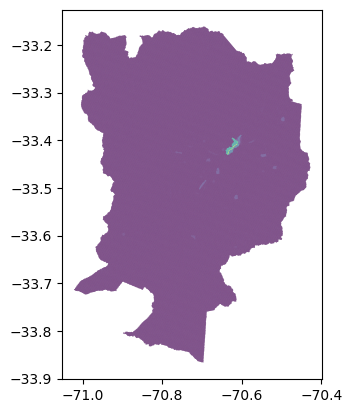

In [36]:
hex_compact.plot('area_ep_m2')

<AxesSubplot: >

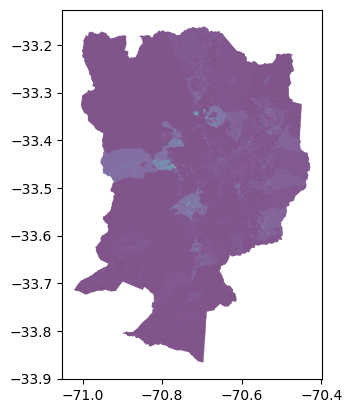

In [37]:
hex_compact.plot('built_up')

Calculate index

In [38]:
hex_compact['compact_count'] = hex_compact['built_up'] / hex_compact['area_ep_m2']
hex_compact.head(4)

,hex_id,geometry,built_up,area_ep_m2,compact_count
0,8ab2c0b00007fff,"POLYGON ((-71.00842 -33.71206, -71.00905 -33.7...",0.0,0.0,NaN
1,8ab2c0b0000ffff,"POLYGON ((-71.00760 -33.71286, -71.00824 -33.7...",0.0,0.0,NaN
2,8ab2c0b00017fff,"POLYGON ((-71.00977 -33.71228, -71.01041 -33.7...",0.0,0.0,NaN
3,8ab2c0b0001ffff,"POLYGON ((-71.00896 -33.71308, -71.00959 -33.7...",0.0,0.0,NaN


<AxesSubplot: >

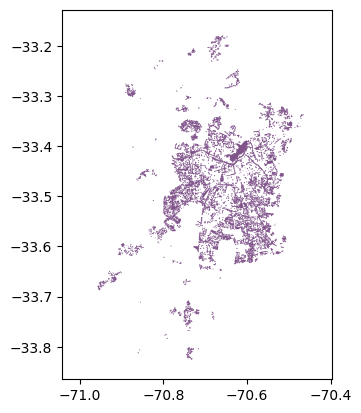

In [39]:
hex_compact.plot('compact_count')

In [30]:
compact_gdf = hex_compact[['hex_id','compact_count']]

## Merge

In [31]:
print(f"Viv:{viv_gdf.shape}.")
print(f"Social viv:{socviv_gdf.shape}.")
print(f"Both viv:{both_viv_gdf.shape}.")
print(f"Hotels:{hotel_gdf.shape}.")
print(f"NDVI:{ndvi_gdf.shape}.")
print(f"Oficina:{oficina_gdf.shape}.")
print(f"Compactness:{compact_gdf.shape}.")
print(f"Temperature:{temp_gdf.shape}.")
print(f"Intersections:{hex_inter.shape}.")
print(f"Noise:{hex_noise.shape}.")

Viv:(51097, 2).
Social viv:(8848, 2).
Both viv:(51106, 3).
Hotels:(58810, 2).
NDVI:(64190, 2).
Oficina:(58810, 2).
Compactness:(17763, 2).
Temperature:(64190, 2).
Intersections:(132311, 2).
Noise:(62225, 2).


In [32]:
# Merge all areal data
hex_aereal = hex_gdf.merge(oficina_gdf, on='hex_id', how='outer')
hex_aereal = hex_aereal.merge(hotel_gdf,on='hex_id', how='outer')
hex_aereal = hex_aereal.merge(both_viv_gdf,on='hex_id', how='outer')
hex_aereal = hex_aereal.merge(compact_gdf,on='hex_id', how='outer')
hex_aereal = hex_aereal.merge(temp_gdf,on='hex_id', how='outer')
hex_aereal = hex_aereal.merge(hex_inter,on='hex_id', how='outer')
hex_aereal = hex_aereal.merge(hex_noise,on='hex_id', how='outer')
# Merge with ndvi is left because some hexs exist in ndvi, but not in hex_gdf from santiago aoi.
hex_aereal = hex_aereal.merge(ndvi_gdf,on='hex_id',how='right')
# Fill NaNs
hex_aereal = hex_aereal.dropna(subset='geometry')
hex_aereal = hex_aereal.fillna(0)

# Show
print(hex_aereal.shape)
hex_aereal.head(2)

(63913, 11)


,hex_id,geometry,oficinas_sum,pct_hotel,viv_sum,pct_social_viv,compact_count,temp_count,inter_count,noise_count,ndvi_mean
0,8ab2c5540647fff,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",1.186889,0.190803,51.747597,0.0,0.0,0.074183,66.0,58.392857,0.135445
1,8ab2c546b0cffff,"POLYGON ((-70.62472 -33.58049, -70.62535 -33.5...",0.000000,0.000000,0.000000,0.0,0.0,0.128523,3.0,52.500000,0.287743


In [33]:
hex_aereal['res']=res

# Show
print(hex_aereal.shape)
hex_aereal.head(2)

(63913, 12)


,hex_id,geometry,oficinas_sum,pct_hotel,viv_sum,pct_social_viv,compact_count,temp_count,inter_count,noise_count,ndvi_mean,res
0,8ab2c5540647fff,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",1.186889,0.190803,51.747597,0.0,0.0,0.074183,66.0,58.392857,0.135445,10
1,8ab2c546b0cffff,"POLYGON ((-70.62472 -33.58049, -70.62535 -33.5...",0.000000,0.000000,0.000000,0.0,0.0,0.128523,3.0,52.500000,0.287743,10


## Save to local

In [34]:
if save:
    hex_aereal.to_file(grl_dir + f'hex_areal_res{res}.gpkg')
    print(f"Saved hex_areal_res{res}.gpkg to local.")

Saved hex_areal_res10.gpkg to local.
